<a href="http://laf-fabric.readthedocs.org/en/latest/" target="_blank"><img align="left" src="images/laf-fabric-small.png"/></a>
<a href="https://shebanq.ancient-data.org" target="_blank"><img align="left"src="images/shebanq_logo_small.png"/></a>
<a href="http://dx.doi.org/10.17026/dans-z6y-skyh" target="_blank"><img align="left"src="images/DANS-logo_small.png"/></a>
<a href="https://www.dbg.de/index.php?L=1" target="_blank"><img align="right" src="images/DBG-small.png"/></a>
<a href="http://www.godgeleerdheid.vu.nl/etcbc" target="_blank"><img align="right" src="images/VU-ETCBC-small.png"/></a>

# Topic analysis

Joint work of Mathias Coeckelbergs and Dirk Roorda.

Mathias is experimenting with topic detection experiments using Mallet.
Here is a way to visualize topics.

We are still in a preliminary stage (2016-04-06).

# Start up

In [1]:
import os, sys, collections, re
import networkx as nx
from glob import glob

import matplotlib.pyplot as plt
%matplotlib inline

# Data source

In [2]:
source='etcbc'
version='4b'

# Topic sources

In [3]:
topic_files = glob('{}_*_keys.txt'.format(source))
topic_files

['etcbc_30_keys.txt',
 'etcbc_40_keys.txt',
 'etcbc_50_keys.txt',
 'etcbc_60_keys.txt',
 'etcbc_70_keys.txt',
 'etcbc_80_keys.txt',
 'etcbc_90_keys.txt']

# Read the topic files

Every topic is a number. We associate a tuple to each topic, namely

    (nn,tp)
    
where `nn` is the number of topics in the file (indicated in the file name) and
`tp` is the topic number within the file.

We collect the topics in a dictionary containing for each topic the set of its words.

In [4]:
mask = re.compile('{}_([0-9]+)_keys.txt'.format(source))
topic = {}
topicsets = set()

def get_topics(n, tfile):
    with open(tfile) as fh:
        for line in fh:
            (tp, nm, word_list) = line.rstrip().split('\t')
            words = word_list.split()
            topic[(n, int(tp))] = words
        
    
for topic_file in topic_files:
    ntopics = int(mask.match(topic_file).group(1))
    topicsets.add(ntopics)
    get_topics(ntopics, topic_file)

print('{} topics found in sets {}'.format(len(topic), ', '.join(sorted(str(x) for x in topicsets))))

420 topics found in sets 30, 40, 50, 60, 70, 80, 90


# Word index

We make an inverse mapping as well: a dictionary that for each word gives the set of topics that contain that word.

In [5]:
word_topic = collections.defaultdict(set)

def word2topic():
    for tp in topic:
        for w in topic[tp]: word_topic[w].add(tp)
    print('{} words found'.format(len(word_topic)))

word2topic()

4725 words found


# Edges

Now we can compute edges. We make a weighted undirected edge between each pair of topics that share a word.
The weight is the number of edges connecting two topics.
We do not add reflexive edges, i.e. edges from a topic to itself.

The method is: walk through all the words, pick the ones that belong to multiple topics, and add the edge weight for
every pair among those multiple topics.

In [6]:
edges = collections.Counter()

def get_edges():
    for w in word_topic:
        tps = sorted(word_topic[w])
        ntps = len(tps)
        if ntps > 1:
            for i in range(ntps - 1):
                for j in range(i+1, ntps):
                    edges[(tps[i], tps[j])] += 1
    print('{} edges found'.format(len(edges)))

get_edges()

4948 edges found


# Writing

We write the graph in ncol format, so that it can be loaded into other tools.
This is not needed for the rest of this notebook.

In [7]:
NCOL_FILE = 'edges.ncol'
def write_ncol():
    with open(NCOL_FILE, 'w') as fh:
        for (e,w) in edges.items(): fh.write('{}-{}\t{}-{}\t{}\n'.format(*e[0], *e[1],w))

write_ncol()

## Distribution of weights
There are edges between topics within the same set, and edges between topics of different sets.

### All edges
Here is the distribution of the weights for all edges.

0, 4568, 239, 56, 24, 20, 13, 5, 2, 1, 6, 1, 8, 2, 3, 0, 0, 0, 0


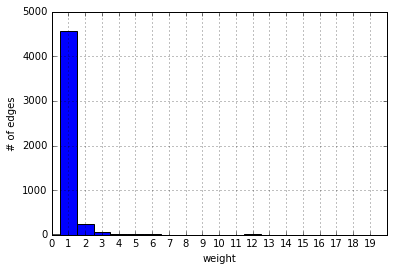

In [8]:
nbins = 20
x = sorted(edges.values())
bins = range(nbins)
n, bins, patches = plt.hist(x, bins, align='left', rwidth=1)
plt.xlabel('weight')
plt.ylabel('# of edges')
plt.xticks(range(nbins))
plt.xlim([0, nbins])
plt.grid(True)
print(', '.join(str(int(round(m))) for m in n))

### Intra-set edges

Here is the distribution of weights on edges that are between topics in the same set.

0, 147, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0


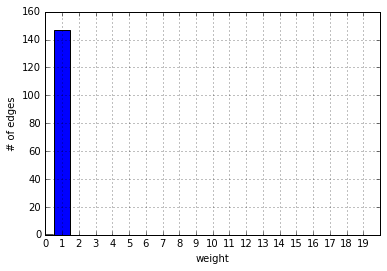

In [9]:
x = sorted(edges[(x,y)] for (x,y) in edges if x[0] == y[0])
bins = range(nbins)
n, bins, patches = plt.hist(x, bins, align='left', rwidth=1)
plt.xlabel('weight')
plt.ylabel('# of edges')
plt.xticks(range(nbins))
plt.xlim([0, nbins])
plt.grid(True)
print(', '.join(str(int(round(m))) for m in n))

We see that topics consist of fairly diverse words, they never happen to share more than one word.

### Inter-set edges

Here is the distribution of weights on edges that are between topics in different sets.

0, 4421, 239, 56, 24, 20, 13, 5, 2, 1, 6, 1, 8, 2, 3, 0, 0, 0, 0


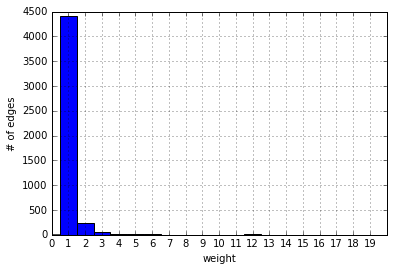

In [10]:
x = sorted(edges[(x,y)] for (x,y) in edges if x[0] != y[0])
bins = range(nbins)
n, bins, patches = plt.hist(x, bins, align='left', rwidth=1)
plt.xlabel('weight')
plt.ylabel('# of edges')
plt.xticks(range(nbins))
plt.xlim([0, nbins])
plt.grid(True)
print(', '.join(str(int(round(m))) for m in n))

# Graphs

We create graphs directly from the nodes in dictionary `topic` and the edges in Counter `edges`.

The parameter `ns` is a set of numbers, indicating the topic sets that we want to include in the graph.

In [85]:
def create_graph(ns, mode='c'): # ns is a set of numbers
    g = nx.Graph()
    g.add_nodes_from(x for x in topic if x[0] in ns)
    if mode == 's':
        neighbours = collections.defaultdict(set)
        sortedns = sorted(ns)
        for (x, y) in zip(sortedns[0:-1], sortedns[1:]): neighbours[x].add(y)
        for (x, y) in zip(sortedns[1:], sortedns[0:-1]): neighbours[x].add(y)
        g.add_weighted_edges_from(
            (x,y,w) for ((x,y),w) in edges.items() if x[0] in ns and y[0] in ns and y[0] in neighbours[x[0]]
        )
    else:
        g.add_weighted_edges_from((x,y,w) for ((x,y),w) in edges.items() if x[0] in ns and y[0] in ns)
    return g

# Drawing

We draw multiple topic sets in one graph, but give topics distinct colors, corresponding to the sets they come from.

The edges get a width and color depending on their weight. Edges of weight 1 are barely visible, only heavier edges will contribute.There are several ways to draw the graphs of combined topic sets:

1. **i=individual** compute layouts per topic set and then superpose the layouts
1. **c=combined** compute one layout for the combined graph
1. **s=separate** position the nodes of the topic sets in different columns

The parameter `mode` (combined) regulates this.

We use the separate layout to view how much correspondence there is between topics in the distinct sets.
We order the topic sets according to their size, and we consider only edges between neighbouring sets.
Moreover, we suppress light edges, so that the focus is on the strong relationships between the topics.

First some style paramaters.

We color the nodes depending on the set they come from. We use the RGB and CMYK standard colors.

We make the size dependent on the mode: mode **s** needs a bigger vertical dimension.

Also in mode **s**, it is convenient to suppress the visibility of light edges. We do this by subtracting a value, EDGE_THRESHOLD, from the width of all edges. Negative widths will become zero.

In [137]:
NCOLORS = {
    30: 'r',
    40: 'g',
    50: 'b',
    60: 'c',
    70: 'm',
    80: 'y',
    90: 'k',
}
NSIZE = dict(
    i=200,
    c=200,
    s=50,
)
XSIZE = dict(
    i=10,
    c=10,
    s=10,
)
YSIZE = dict(
    i=10,
    c=10,
    s=20,
)
EDGE_THRESHOLD = dict(
    i=0,
    c=0,
    s=2,
)

Here is the draw function

In [188]:
def draw_graph(ns, mode='c'): # ns is a set of numbers
    xsize, ysize = (p[mode] for p in (XSIZE, YSIZE))
    if mode not in 'cis':
        print('Unknown mode "{}".format(mode)')
        return

    plt.figure(figsize=(xsize, ysize))
    if mode == 's':
        plt.xlim(-1, xsize+1)
        plt.ylim(-1, ysize+1)
    g = create_graph(ns, mode=mode)
    if mode == 'c':
        pos = nx.spring_layout(
            g,
            k=1,
        )
    elif mode == 'i':
        gs = {}
        for n in ns: gs[n] = create_graph({n})
        pos = {}
        for n in ns: pos.update(nx.spring_layout(
            gs[n],
            k=None,
        ))
    elif mode == 's':
        pos = {}
        srtns = sorted(ns)
        lns = len(srtns)
        xpos = {}
        if lns == 1: xpos[srtns[0]] = xsize / 2
        else:
            for j in range(lns): xpos[srtns[j]] = xsize * j / (lns - 1)
        for n in ns:
            srtnds = sorted(nd for nd in g.nodes() if nd[0] == n)
            lnds = len(srtnds)
            if lnds == 1: pos[srtnds[0]] = (xpos[n], ysize / 2)
            else:
                for j in range(lnds): pos[srtnds[j]] = (xpos[n], ysize * j / (lnds - 1))

    nx.draw(g, pos,
        node_size=NSIZE[mode],
        width=[max((-EDGE_THRESHOLD[mode] + g.get_edge_data(*x)['weight'], 0)) for x in g.edges()],
        node_color=[NCOLORS[n] for (n,t) in g.nodes()],
        edge_color=[g.get_edge_data(*x)['weight'] for x in g.edges()],
        edge_cmap=plt.cm.Greys,
        edge_vmin=-5,
        edge_vmax=20,
        alpha=1,
        linewidths=0,
    )
    print('{} x {}'.format(plt.xlim(), plt.ylim()))

## Draw one topic set at a time

(-1.5, 1.5) x (-1.5, 1.5)


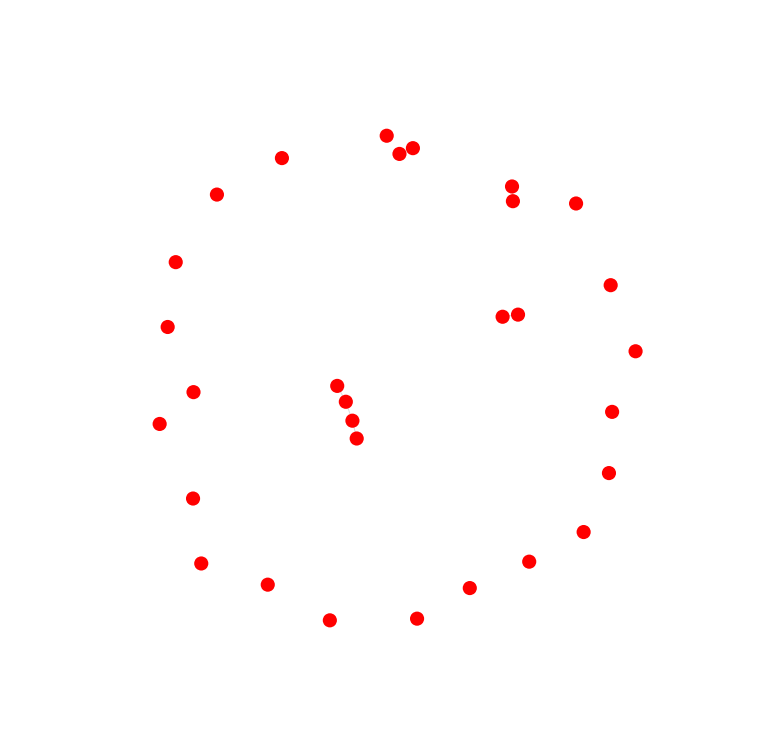

In [189]:
draw_graph({30}, mode='i')

(-1.5, 1.5) x (-1.5, 1.5)


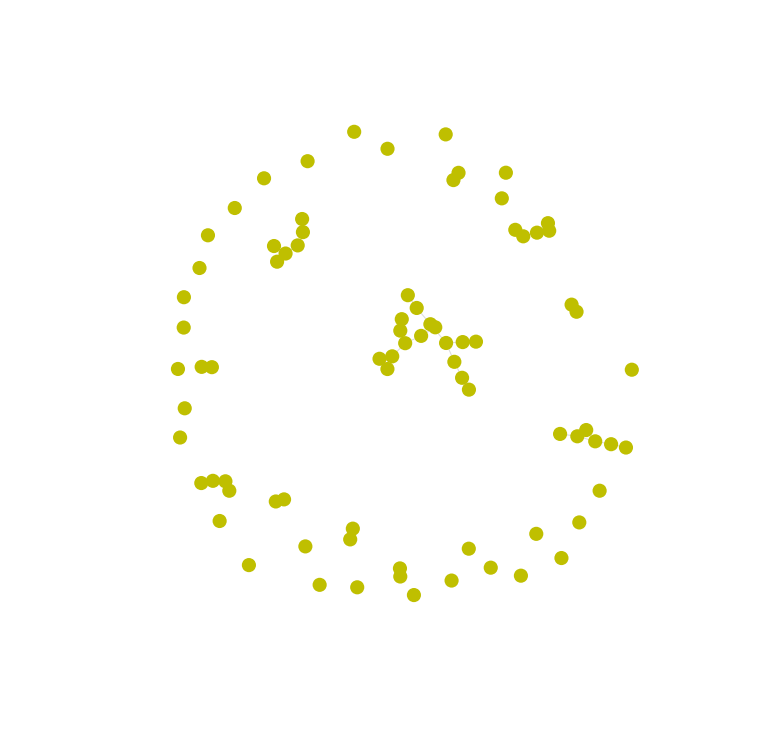

In [190]:
draw_graph({80}, mode='i')

## Draw multiple topic sets at a time

(-1.5, 1.5) x (-1.5, 1.5)


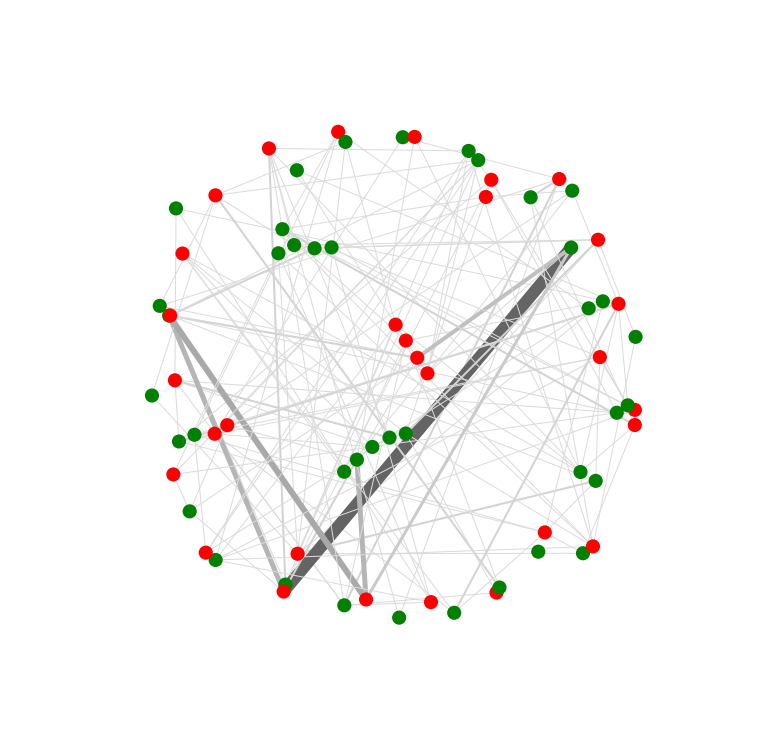

In [191]:
draw_graph({30, 40}, mode='i')

(-1.5, 1.5) x (-1.5, 1.5)


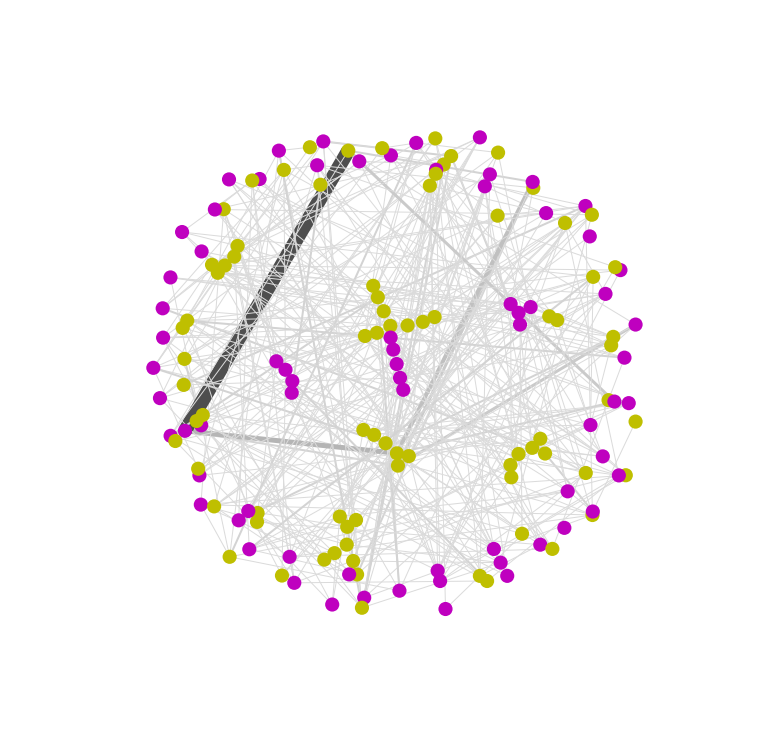

In [192]:
draw_graph({70, 80}, mode='i')

(-1.5, 1.5) x (-1.5, 1.5)


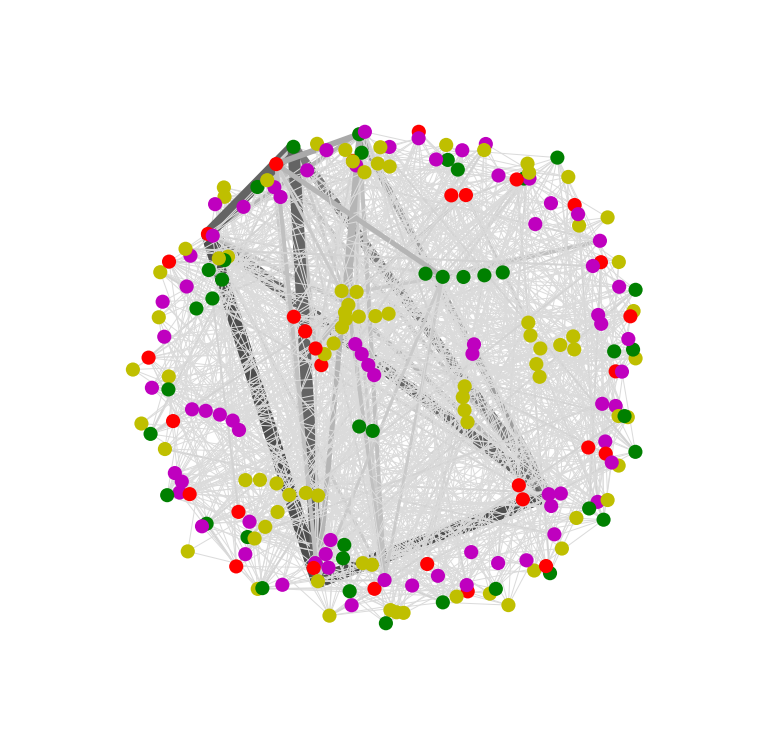

In [193]:
draw_graph({30,40,70,80}, mode='i')

# Draw multiple topic sets at once

In the previous examples, we did the graph layout per topic set, and then combined the layouts.
Now we do a layout at once.

(-1.5, 1.5) x (-1.5, 1.5)


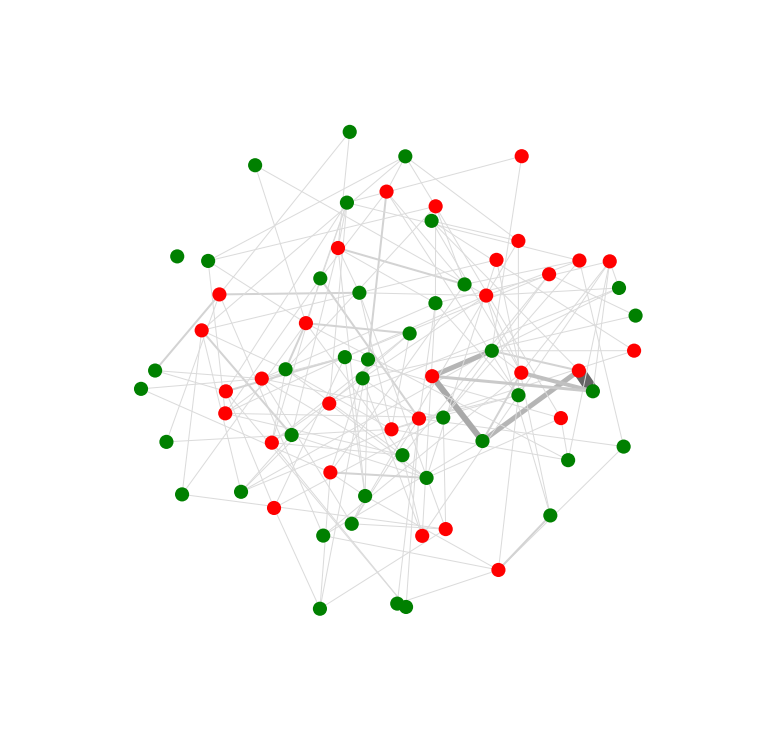

In [194]:
draw_graph({30, 40}, mode='c')

(-1.5, 1.5) x (-1.5, 1.5)


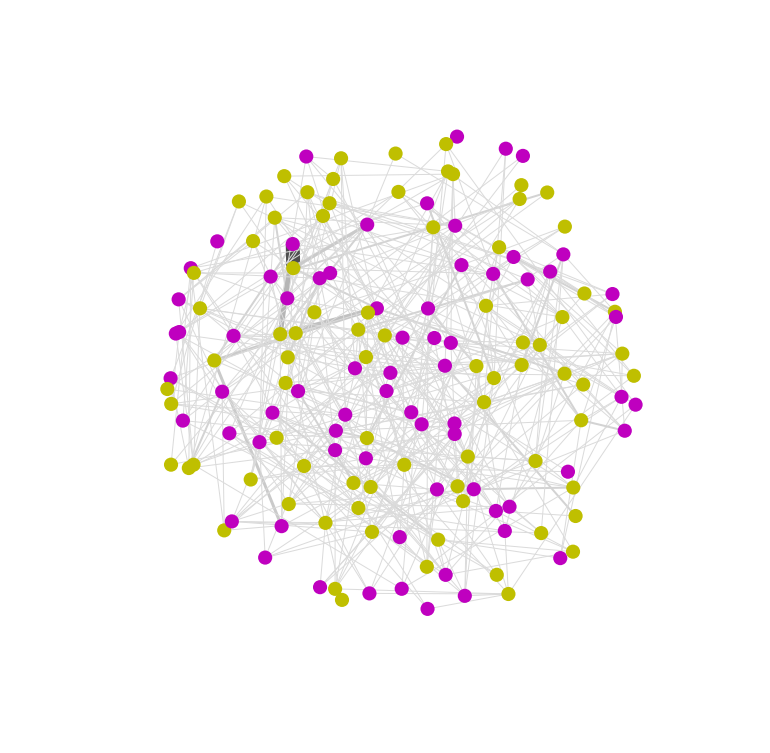

In [195]:
draw_graph({70, 80}, mode='c')

(-1.5, 1.5) x (-1.5, 1.5)


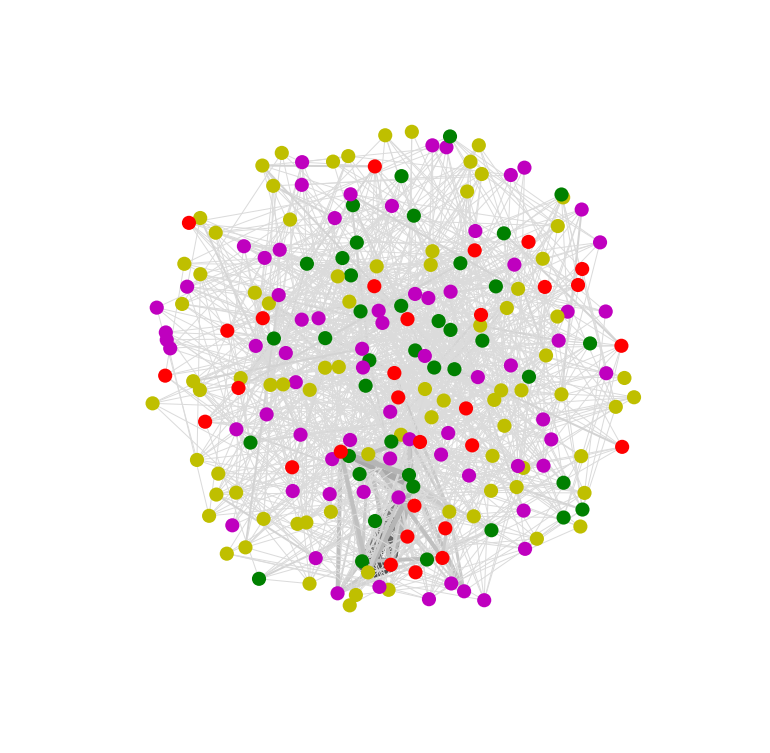

In [196]:
draw_graph({30,40,70,80}, mode='c')

## Draw all topic sets in separated mode

(-1.0, 11.0) x (-1.0, 21.0)


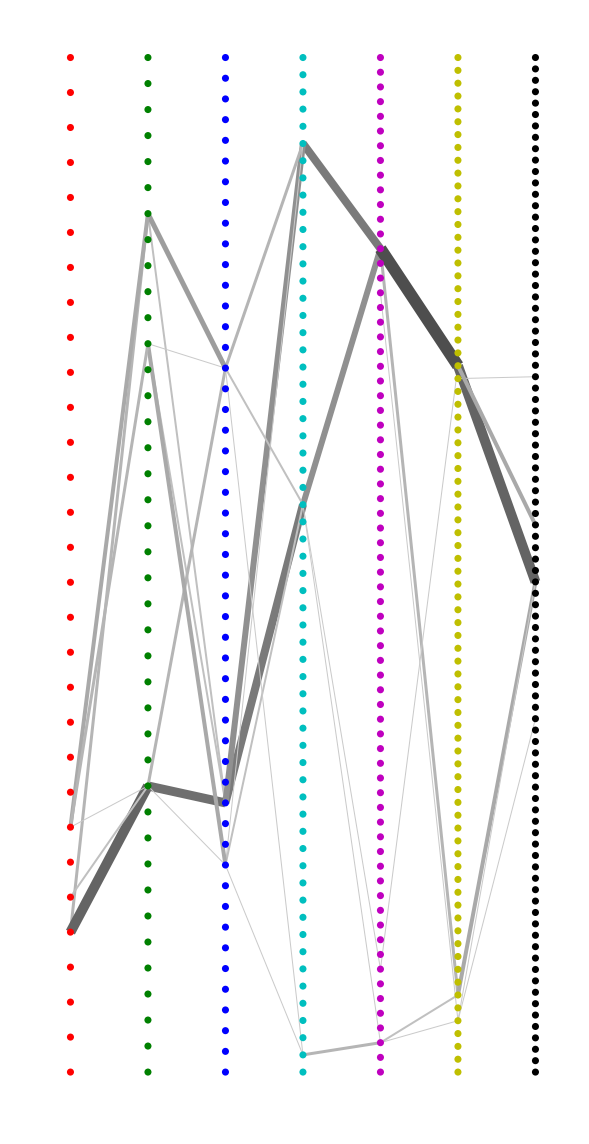

In [197]:
draw_graph(topicsets, mode='s')

Topic detection is stable if there are many strong links between topics in different sets.

For example, if there is a topic in one set that can be labeled as *country*, 
we expect that the other sets also have such a topic, and that the words that support it in one set
have a large intersection with the words that support it in an other set.

However, in these visualizations, we see only a few topics that are strongly related.